In [1]:
import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import enterprise_extensions
from enterprise_extensions import models, sampler

In [2]:
# matplotlib plotting params
def figsize(scale):
    fig_width_pt = 513.17 #469.755    # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27         # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0    # Aesthetic ratio
    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = fig_width * golden_mean              # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,
        'ytick.major.size':6,
        'ytick.minor.size':3,
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5)}

plt.rcParams.update(params)

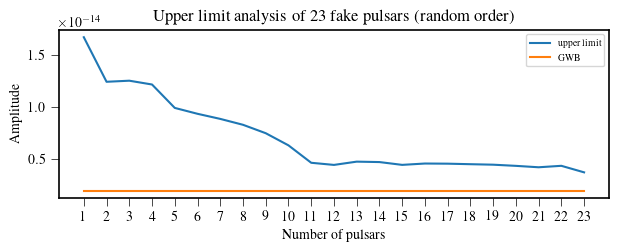

In [66]:
with open('./upper_limits.txt', 'r') as f:
    number, ul = np.loadtxt(f, unpack=True)

def gwb_const(number):
    zero = np.zeros(len(number))
    return zero + 2e-15

plt.figure(figsize=[2*3.5503666805036667, 2.1942472810764047])
plt.plot(number, ul, label='Upper Limit')
plt.plot(number, gwb_const(number), label='GWB')
plt.legend()
plt.xlabel('Number of pulsars')
plt.ylabel('Amplitude')
plt.title('Upper limit analysis of 23 fake pulsars (random order)')
plt.xticks(number);
plt.savefig('23_random.png', bbox_inches='tight')

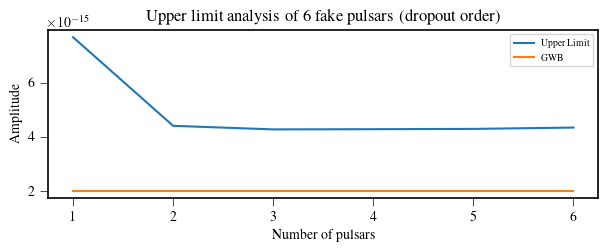

In [68]:
with open('./upper_limit_best.txt', 'r') as f:
    number, ul = np.loadtxt(f, unpack=True)

def gwb_const(number):
    zero = np.zeros(len(number))
    return zero + 2e-15

plt.figure(figsize=[2*3.5503666805036667, 2.1942472810764047])
plt.plot(number, ul, label='Upper Limit')
plt.plot(number, gwb_const(number), label='GWB')
plt.legend()
plt.xlabel('Number of pulsars')
plt.ylabel('Amplitude')
plt.title('Upper limit analysis of 6 fake pulsars (dropout order)')
plt.xticks(number);
plt.savefig('23_best.png', bbox_inches='tight')

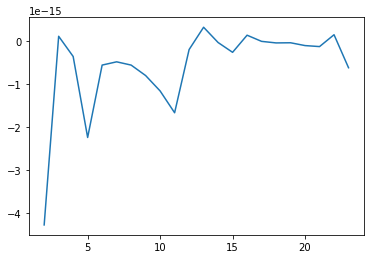

In [28]:
number_added = np.delete(number, 0)
dul = np.diff(ul)
plt.plot(number_added, dul)

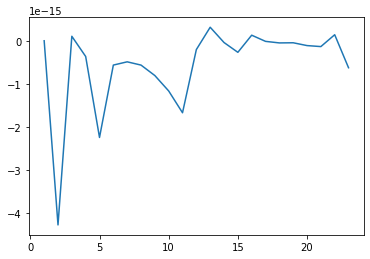

In [31]:
dul0 = np.insert(dul, 0, 0)
plt.plot(number, dul0)

In [46]:
merged_list = [(number[i], dul0[i]) for i in range(len(number))]

In [49]:
sorted_list = sorted(merged_list, key=lambda x: x[1])
print(sorted_list)

[(2.0, -4.2680471963488615e-15), (5.0, -2.241505080961879e-15), (11.0, -1.6688301466475604e-15), (10.0, -1.1634216479244651e-15), (9.0, -8.064379685343652e-16), (23.0, -6.254057262915136e-16), (8.0, -5.639958773261588e-16), (6.0, -5.637501738187397e-16), (7.0, -4.884325466905339e-16), (4.0, -3.645456503509547e-16), (15.0, -2.6818925133500377e-16), (12.0, -2.0433617562243766e-16), (21.0, -1.3515642521059693e-16), (20.0, -1.119548204629932e-16), (18.0, -5.018019294568267e-17), (19.0, -4.67725041285147e-17), (14.0, -4.09052886907435e-17), (17.0, -1.426048051262496e-17), (1.0, 0.0), (3.0, 1.0374688559286124e-16), (16.0, 1.2869597978405548e-16), (22.0, 1.3946848629656878e-16), (13.0, 3.130465862602507e-16)]


In [50]:
best_first = np.array(sorted_list)

In [55]:
print(best_first)

[[ 2.00000000e+00 -4.26804720e-15]
 [ 5.00000000e+00 -2.24150508e-15]
 [ 1.10000000e+01 -1.66883015e-15]
 [ 1.00000000e+01 -1.16342165e-15]
 [ 9.00000000e+00 -8.06437969e-16]
 [ 2.30000000e+01 -6.25405726e-16]
 [ 8.00000000e+00 -5.63995877e-16]
 [ 6.00000000e+00 -5.63750174e-16]
 [ 7.00000000e+00 -4.88432547e-16]
 [ 4.00000000e+00 -3.64545650e-16]
 [ 1.50000000e+01 -2.68189251e-16]
 [ 1.20000000e+01 -2.04336176e-16]
 [ 2.10000000e+01 -1.35156425e-16]
 [ 2.00000000e+01 -1.11954820e-16]
 [ 1.80000000e+01 -5.01801929e-17]
 [ 1.90000000e+01 -4.67725041e-17]
 [ 1.40000000e+01 -4.09052887e-17]
 [ 1.70000000e+01 -1.42604805e-17]
 [ 1.00000000e+00  0.00000000e+00]
 [ 3.00000000e+00  1.03746886e-16]
 [ 1.60000000e+01  1.28695980e-16]
 [ 2.20000000e+01  1.39468486e-16]
 [ 1.30000000e+01  3.13046586e-16]]


In [19]:
with open('./snglpsr3.5.txt', 'r') as f:
    number, ul = np.loadtxt(f, unpack=True)
# with open('./snglpsr.txt', 'r') as f:
#     number2, ul2 = np.loadtxt(f, unpack=True)

# number = np.insert(number, len(number), 22)
# print(number)
# ul = np.insert(ul, 2, 0)
# print(ul)


def gwb_const(number, const):
    zero = np.zeros(len(number))
    return zero + const

plt.figure(figsize=[2*3.5503666805036667, 2.1942472810764047])
# plt.plot(number2, ul2, label='Upper Limit 2')
plt.plot(number, ul, label='Upper Limit 3.5e-15')
# plt.plot(number2, gwb_const(number2, 2e-15), label='GWB 2')
plt.plot(number, gwb_const(number, 3.5e-15), label='GWB 3.5e-15')
plt.legend()
plt.xlabel('Pulsar number in list')
plt.ylabel('Amplitude')
plt.title('Upper limit analysis of single pulsars')
plt.xticks(number);
plt.savefig('snglpsr_3.5.png', bbox_inches='tight')

In [20]:
merged_list = [(number[i], ul[i]) for i in range(len(number))]

In [21]:
sorted_list = sorted(merged_list, key=lambda x: x[1])
print(sorted_list)

[(11.0, 5.281641084423741e-15), (9.0, 5.3925839683562496e-15), (16.0, 5.55487114422428e-15), (21.0, 7.563251074410513e-15), (8.0, 1.0019570870854236e-14), (2.0, 1.2869669744224348e-14), (3.0, 1.4687729673239948e-14), (7.0, 1.89639350814825e-14), (13.0, 1.91196869940124e-14), (14.0, 1.924965110954043e-14), (19.0, 1.9346678907127417e-14), (0.0, 2.147174873408699e-14), (4.0, 2.4210235243212056e-14), (17.0, 2.441930393536249e-14), (18.0, 2.516691452102313e-14), (5.0, 3.3765681785256725e-14), (6.0, 3.4759446070803813e-14), (20.0, 3.710351731142029e-14), (12.0, 3.9291962188393246e-14), (1.0, 4.520175735417798e-14), (10.0, 1.035880735037003e-13), (15.0, 5.21693503344105e-13)]


In [22]:
best_first = np.array(sorted_list)

In [25]:
print(best_first)

[[1.10000000e+01 5.28164108e-15]
 [9.00000000e+00 5.39258397e-15]
 [1.60000000e+01 5.55487114e-15]
 [2.10000000e+01 7.56325107e-15]
 [8.00000000e+00 1.00195709e-14]
 [2.00000000e+00 1.28696697e-14]
 [3.00000000e+00 1.46877297e-14]
 [7.00000000e+00 1.89639351e-14]
 [1.30000000e+01 1.91196870e-14]
 [1.40000000e+01 1.92496511e-14]
 [1.90000000e+01 1.93466789e-14]
 [0.00000000e+00 2.14717487e-14]
 [4.00000000e+00 2.42102352e-14]
 [1.70000000e+01 2.44193039e-14]
 [1.80000000e+01 2.51669145e-14]
 [5.00000000e+00 3.37656818e-14]
 [6.00000000e+00 3.47594461e-14]
 [2.00000000e+01 3.71035173e-14]
 [1.20000000e+01 3.92919622e-14]
 [1.00000000e+00 4.52017574e-14]
 [1.00000000e+01 1.03588074e-13]
 [1.50000000e+01 5.21693503e-13]]


In [26]:
print(best_first[:, 0])

[11.  9. 16. 21.  8.  2.  3.  7. 13. 14. 19.  0.  4. 17. 18.  5.  6. 20.
 12.  1. 10. 15.]


In [27]:
best_list = []
for i in range(len(best_first)):
    best_list.append(int(best_first[i, 0]))
print(best_list)

[11, 9, 16, 21, 8, 2, 3, 7, 13, 14, 19, 0, 4, 17, 18, 5, 6, 20, 12, 1, 10, 15]


In [ ]:
with open('./uplimit_order.txt', 'r') as f:
    number, ul = np.loadtxt(f, unpack=True)

def gwb_const(number):
    zero = np.zeros(len(number))
    return zero + 2e-15

plt.figure(figsize=[2*3.5503666805036667, 2.1942472810764047])
plt.plot(number, ul, label='Upper Limit')
plt.plot(number, gwb_const(number), label='GWB')
plt.legend()
plt.xlabel('Number of pulsars')
plt.ylabel('Amplitude')
plt.title('Upper limit analysis of PTA with GWB UL ordering')
plt.xticks(number);
plt.savefig('snglpsr.png', bbox_inches='tight')